In [1]:
using Plots
using SparseArrays
using LinearAlgebra
using Polynomials
using DataFrames

## Coefficients $c_{k}^{(r)}$ Table for Finding Second Derivative

In [2]:
# Define the maximum value of r for which to create the table (upto the 2r+1 th formula)
r_max = 7

# Create an empty zero matrix
coeff_table = zeros(r_max,r_max + 1)

# Solve the system of r equations with r unknowns
for r in range(start=1, stop=r_max, step=1)
    
    # Create rxr matrix
    mat1 = inv(2*[(i^(2*j))/factorial(2j) for i in 1:r, j in 1:r])   
    
    # Create rx2r+1 matrix
    # RHS Matrix can be thought of as the concatenation of three different matrices
    mat2 = mat1*(hcat(rotr90(Matrix(I,r,r)), fill(-2, r), Matrix(I,r,r)))
    
    global coeff_table[r,1:r+1] = mat2[1,r+1:(2r+1)] 
end

DataFrame(coeff_table, ["$i" for i in 0:r_max]) 

Row,0,1,2,3,4,5,6,7
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.5,1.33333,-0.0833333,0.0,0.0,0.0,0.0,0.0
3,-2.72222,1.5,-0.15,0.0111111,0.0,0.0,0.0,0.0
4,-2.84722,1.6,-0.2,0.0253968,-0.00178571,0.0,0.0,0.0
5,-2.92722,1.66667,-0.238095,0.0396825,-0.00496032,0.00031746,0.0,0.0
6,-2.98278,1.71429,-0.267857,0.0529101,-0.00892857,0.00103896,-6.01251e-5,0.0
7,-3.02359,1.75,-0.291667,0.0648148,-0.0132576,0.00212121,-0.000226625,1.18929e-5


## Initialise the wavefunction

In [3]:
# Define constants and step sizes

h_bar = 1
m = 1
dt = 0.01                                   # Time step
dx = 0.1                                    # Space step
L = 10                                      # Half-length of box
N = 500                                     # No. of time steps
J = Int(2L/dx)                              # No. of space steps

# Discretize space by creating an array
x = range(-L,L,step=dx)

-10.0:0.1:10.0

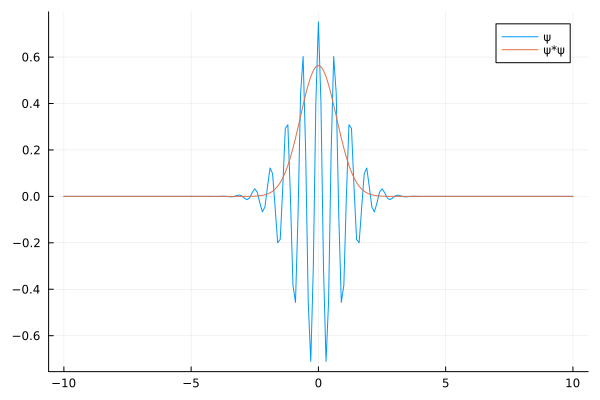

In [19]:
# Initialise the wavefunction
k0 = 10                                     # Initial momentum
sigma = 1                                   # Standard deviation

function g(x)
    return (1/(pi*sigma^2)^(1/4))*(exp((k0*x)*im)*(exp(-x^2/(2*sigma^2))))
end

# Matrix for storing wavefuction for each time
psi_0 = g.(x)

# Plot initial wavefunction and probability density 
plot(x, [real.(psi_0), real.(diag(conj(psi_0) * transpose(psi_0)))], label=["ψ" "ψ*ψ"])

# Wave Propagation

In [5]:
# Define constants
b = im*h_bar*dt/(2m*dx^2)
z_1 = -2

a = coeff_table * b/z_1 

# Define the potential 
V = zeros(1,J+1)

1×201 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Creating A matrix

In [6]:
# Create a sparse matrix 
A = spzeros(ComplexF64, J+1, J+1) 

for i in 1:J+1, j in 1:J+1
    
    # Define diagonal terms
    if i == j 
        A[i,i] = 1.0 + a[r_max, 1] - im*dt*V[i]/(z_1*h_bar)
    
    elseif abs(i-j) < r_max + 1
        A[i,j] = a[r_max, abs(i-j)+1]
    end
end

## Create complete  ψ matrix for different time steps

[ Info: Saved animation to /home/mariya/Documents/PYL800/Assignment 1/tmp.gif


Plots.AnimatedGif("/home/mariya/Documents/PYL800/Assignment 1/tmp.gif")
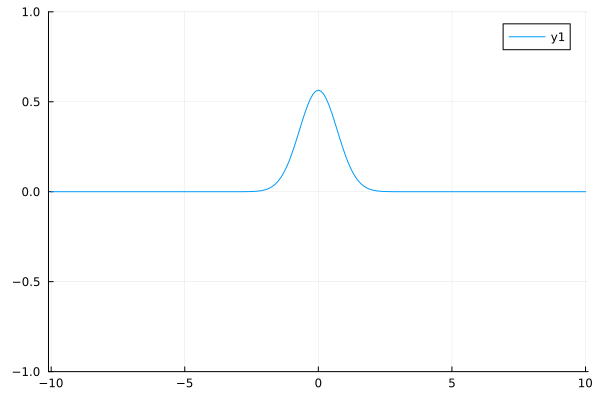

In [7]:
# Initialise the ψ matrix 
psi_x = psi_0

for n in 1:N
    
    # Next wavefunction
    psi_new = inv(Matrix(A)) * SparseArrays.conj(A) * psi_x[:,n]
    
    # Concatenate next wavefunction
    psi_x = hcat(psi_x,psi_new)
end

# Forming GIF
@gif for i in 1:N
        
        # Plot the probability density ψ*ψ
        P = conj(psi_x[:,i]) * transpose(psi_x[:,i])
        plot(x, real(diag(P)), xlims = (-10.1,10.1), ylims = (-1,1))
     end

## To check if the wavefunction is normalised 

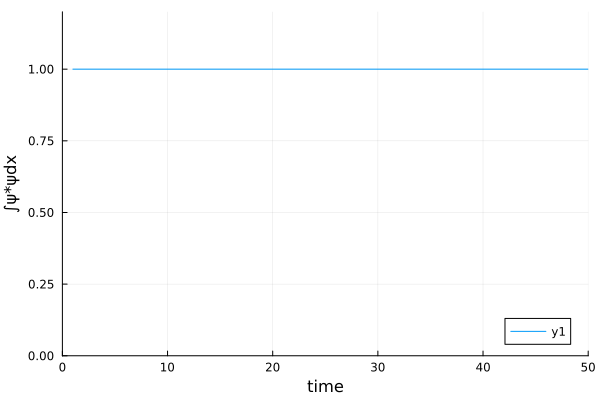

In [8]:
B = transpose(conj(psi_x)) * psi_x * dx
p = real(diag(B))

plot(p,  xlim=(0,50), ylim=(0,1.2), xlabel=("time"), ylabel=("∫ψ*ψdx"))

# Padé Approximant

## Root finding 

In [9]:
# Define a function to find Mth order roots of the numerator of the Padé approximant of exponential function
function roots_pade(M)
    
    # Finding b coefficients
    A = inv([ 1/factorial(i+j-1) for i in 1:M, j in 1:M])
    B = -[1/factorial(M+i) for i in 1:M]

    b_coeff = vcat([1], reverse(A*B))
    
    # Finding a coefficients
    C = spzeros(M+1,M+1)
    for i in 1:M+1, j in 1:M+1
        if i >= j
            C[i,j] = 1/factorial(i-j)
        end
    end

    a_coeff = C*b_coeff
    
    # Create the numerator and denominator polynomials
    poly_num = Polynomial(a_coeff)
    poly_den = Polynomial(b_coeff)
    
    # Return roots of the numerator
    return roots(poly_num)
end

roots_pade (generic function with 1 method)

In [10]:
# Define the maximum value of M for which to create the roots table
M_max = 5

# Create the table
table = [roots_pade(i) for i in 1:M_max]

# Printing the table
for i in 1:M_max 
    for j in 1:length(table[i])
        
        # Round off to 5 decimal places
        print(round(table[i][j],digits = 5), "   ")
    end
    print("\n") 
end

-2.0   
-3.0 - 1.73205im   -3.0 + 1.73205im   
-4.64437 + 0.0im   -3.67781 - 3.50876im   -3.67781 + 3.50876im   
-5.79242 - 1.73447im   -5.79242 + 1.73447im   -4.20758 - 5.31484im   -4.20758 + 5.31484im   
-7.29348 + 0.0im   -6.70391 - 3.48532im   -6.70391 + 3.48532im   -4.64935 - 7.14205im   -4.64935 + 7.14205im   


## Define r and M values 

In [11]:
r = 3
M = 2

2

## Wave propagation 

In [12]:
# Define a funciton that calculates the wavefunction at the next time step
# The code is the same as before

function psi_next(psi)
    for i in 1:M
    
    z_1 = table[M][i]
    a = coeff_table * b/z_1   

    # Making A matrix

    A = spzeros(ComplexF64, J+1, J+1) 

    for i in 1:J+1, j in 1:J+1
        if i == j 
            A[i,i] = 1.0 + a[r_max, 1] - im*dt*V[i]/(z_1*h_bar)
        elseif abs(i-j) < r_max + 1
            A[i,j] = a[r_max, abs(i-j)+1]
        end
    end
    
    psi = inv(Matrix(A)) * SparseArrays.conj(A) * psi
    end
    
    return psi
end

psi_next (generic function with 1 method)

[ Info: Saved animation to /home/mariya/Documents/PYL800/Assignment 1/tmp.gif


Plots.AnimatedGif("/home/mariya/Documents/PYL800/Assignment 1/tmp.gif")
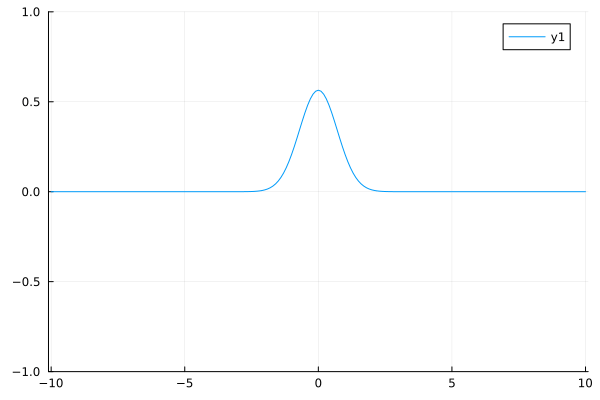

In [13]:
# Initialise the ψ matrix 
psi_x = psi_0

# Propagate the wavefunction 
for n in 1:N
    
    # Concatenate next wavefunction
    psi_x = hcat(psi_x, psi_next(psi_x[:,n]))
end

# Forming GIF
@gif for i in 1:N
    
     # Plot the probability density ψ*ψ
    P = conj(psi_x[:,i]) * transpose(psi_x[:,i])
    plot(x, real(diag(P)), xlims = (-10.1,10.1), ylims = (-1,1))
end

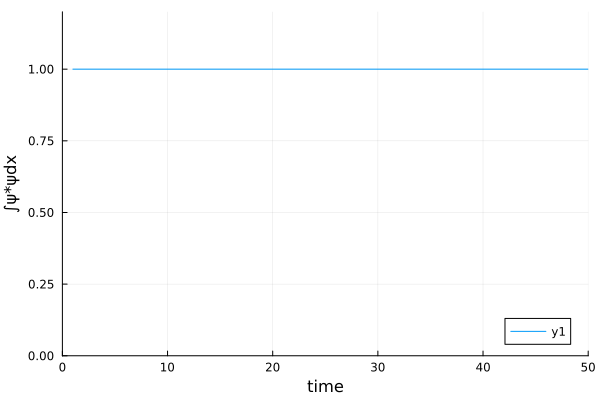

In [14]:
# Check Normalisation

B = transpose(conj(psi_x)) * psi_x * dx

p = real(diag(B))
plot(p,  xlim=(0,50), ylim=(0,1.2), xlabel=("time"), ylabel=("∫ψ*ψdx"))